- title: My notebook
- author: John Doe
- date: 2018-05-12
- category: pyhton
- tags: pip

<!-- PELICAN_BEGIN_SUMMARY -->

<img src="http://jakevdp.github.io/images/ChutesAndLadders-sim.gif" alt='[img: Chutes and Ladders animated simulation]'>

This weekend I found myself in a particularly drawn-out game of Chutes and Ladders with my four-year-old. If you've not had the pleasure of playing it, Chutes and Ladders (also sometimes known as [Snakes and Ladders](https://en.wikipedia.org/wiki/Snakes_and_Ladders)) is a classic kids board game wherein players roll a six-sided die to advance forward through 100 squares, using "ladders" to jump ahead, and avoiding "chutes" that send you backward. It's basically a glorified random walk with visual aids to help you build a narrative. Thrilling. But she's having fun practicing counting, learning to win and lose gracefully, and developing the requisite skills to be a [passionate sports fan](https://xkcd.com/904/), so I play along.

On the approximately twenty third game of the morning, as we found ourselves in a near endless cycle of climbing ladders and sliding down chutes, never quite reaching that final square to end the game, I started wondering how much longer the game could last: what is the expected length of a game? How heavy are the tails of the game length distribution? How succinctly could I answer those questions in Python? And then, at some point, it [clicked](https://twitter.com/jakevdp/status/942456865580924928): Chutes and Ladders is memoryless — the effect of a roll depends only on where you are, not where you've been — and so it can be modeled as a Markov process! By the time we (finally) hit square 100, I basically had this blog post written, at least in my head.

When I [tweeted about this](https://twitter.com/jakevdp/status/942456865580924928), people pointed me to a [number](http://www.datagenetics.com/blog/november12011/) of [similar](https://gist.github.com/CamDavidsonPilon/1639d06c448904afaf7b7449910f3b72) [treatments](https://math.byu.edu/~jeffh/mathematics/games/chutes/chutes.html) of [Chutes](https://roycoding.github.io/chutes-ladders-d3/) & [Ladders](https://scipython.com/book/chapter-6-numpy/additional-problems/analysing-snakes-and-ladders-as-a-markov-chain/), so I'm under no illusion that this idea is original.
Think of this as a blog post version of a dad joke: my primary goal is not originality, but self-entertainment, and if anyone else finds it entertaining that's just an added bonus.

<!-- PELICAN_END_SUMMARY -->

## Direct Simulation

The most straightforward way to get a handle on the dynamics of the game is through direct simulation: if we simulate enough games, we'll obtain a distribution of game lengths that will approximate the "true" distribution.
The first step in this is to examine the game board and somehow encode the positions of the chutes and ladders on the grid:

<img src='http://jakevdp.github.io/images/ChutesAndLadders-board.gif' width=400 alt='[img: Chutes and ladders game board]'/>

*(Image source: [uncyclopedia](http://uncyclopedia.wikia.com/wiki/Chutes_and_Ladders))*

We'll use a Python dictionary to store these positions:

In [1]:
# Mapping of start : end spaces of chutes & ladders
CHUTES_LADDERS = {1:38, 4:14, 9:31, 16:6, 21:42, 28:84, 36:44,
                  47:26, 49:11, 51:67, 56:53, 62:19, 64:60,
                  71:91, 80:100, 87:24, 93:73, 95:75, 98:78}

With this in place, we can simulate the game in a few lines of Python:

In [2]:
from random import Random


def simulate_cl_game(rseed=None, max_roll=6):
    """
    Simulate a full Chutes & Ladders game
    and return the number of turns to finish
    """
    rand = Random(rseed)
    position = 0
    turns = 0
    while position < 100:
        turns += 1
        roll = rand.randint(1, max_roll)
        
        # if the roll takes us past square 100, we don't move
        if position + roll > 100:
            continue
            
        # otherwise, move the position according to the roll
        position += roll
        
        # go up/down any chute/ladder
        position = CHUTES_LADDERS.get(position, position)
    return turns

Calling the function tells us how many moves were required to finish the particular game:

In [3]:
simulate_cl_game()

21

If we simulate many games, the result will be a distribution of how many turns are required to get to the end:

In [4]:
# Jupyter notebook plotting setup & imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/Users/User/Desktop/Repositorios/Cobb-Douglas-Funktion/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


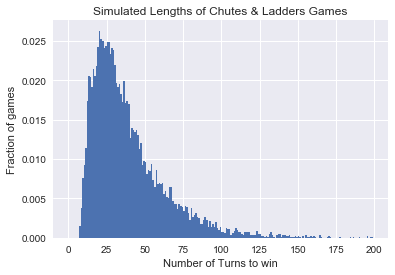

In [5]:
sim_games = [simulate_cl_game() for i in range(10000)]

plt.hist(sim_games, bins=range(200), normed=True)
plt.xlabel('Number of Turns to win')
plt.ylabel('Fraction of games')
plt.title('Simulated Lengths of Chutes & Ladders Games');

This gives us some insight, but the problem here is that the result is just an estimate of the "true" distribution; to make our estimate more precise will require many more simulations, and this can get computationally expensive.

Fortunately, there's another approach.

## Chutes and Ladders as a Markov Process

Instead of brute force simulation, we might think about the game probabilistically. On any given turn, there are six equally probable options: rolling a 1, 2, 3, 4, 5, or 6.
Depending on which space you start on, these lead to six well-defined results.
For example, the first turn, the possibilities are the squares 38, 2, 3, 14, 5, or 6, each with equal probability. We could encode this set of probabilities as a vector of length 101, with ``1/6`` in each associated index (here the zeroth element represents the start of the game, off of the board):

    0: [0, 0, 1/6, 1/6, 0, 1/6, 1/6, 0, 0, ...]
    
Each entry in this vector is the probability of going from square zero to the corresponding square. This vector *completely describes* the first turn of the game.

Similarly, we could construct the vector describing turns from square 2:

    2: [0, 0, 0, 1/6, 0, 1/6, 1/6, 1/6, 1/6, 0, 0, ...]
    
Again, this completely describes any turn of the game that starts at square two.

The key insight is that Chutes and Ladders is *memoryless*; if you're on, say, square 19, it doesn't matter if you got there by sliding down from square 62, or by rolling a five from square 14 – the probabilities on the next turn are exactly the same.

This kind of situation: a sequence of probabilistic transitions from one state to another with no memory of previous states, is known as a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) or Markov Process,
and can be *entirely* described by a *N x N* transition matrix where *N* is the number of states in the system (101 states for Chutes and Ladders).
The columns of the matrix contain the probability vectors we discussed above, such that element *(n, m)* is the probability of transitioning to element *n* when starting from element *m*.

Let's create a Markov transition matrix for Chutes and Ladders:

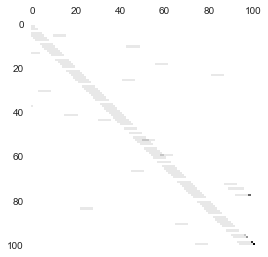

In [6]:
import numpy as np

def cl_markov_matrix(max_roll=6, jump_at_end=True):
    """
    Create a Markov transition matrix
    
    If jump_at_end is True, then apply ladder/chute jumps at the end of each turn.
    If False, then apply them at the beginning of the next turn.
    """  
    # Create the basic transition matrix:
    mat = np.zeros((101, 101))
    for i in range(101):
        mat[i + 1:i + 1 + max_roll, i] = 1. / max_roll
        
    # We could alternatively use scipy.linalg.circulent as follows:
    # mat = circulant([0, *np.ones(max_rolls) / 6, *np.zeros(100)])[:101, :101]

    # rolls off the end of the board don't change the state;
    # add these probabilities to the diagonal
    mat[range(101), range(101)] += 1 - mat.sum(0)

    # account for the presence of chutes and ladders
    # we'll do this via  another transition matrix
    cl_mat = np.zeros((101, 101))
    ind = [CHUTES_LADDERS.get(i, i) for i in range(101)]
    cl_mat[ind, range(101)] = 1
    if jump_at_end:
        return cl_mat @ mat
    else:
        return mat @ cl_mat

mat = cl_markov_matrix()
plt.matshow(mat)
plt.grid(False)

The above matrix encodes *everything you need to know* about the game of Chutes and Ladders. (Note that there are two ways to construct this matrix: applying the chutes and ladders jumps at the end of each turn, as typically played, or applying them at the beginning of the next turn. We make this second option available for later).

The game starts with a state vector describing 100% probability of being in the zeroth state:

    v_0 = [1, 0, 0, 0, 0...]
    
If you think about it for a while, you can convince yourself that the way to evolve this (probabilistically) to the next state is to left-multiply the vector by our transition matrix:

In [7]:
np.set_printoptions(suppress=True, precision=2)

v_0 = [1, *np.zeros(100)]
mat @ v_0

array([0.  , 0.  , 0.17, 0.17, 0.  , 0.17, 0.17, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.17, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

The result is precisely the vector we described above, encoding the probabilities of game state after one move.

To perform multiple moves, we could repeatedly multiply this vector by our transition matrix, but repeating such an operation can compound floating-point inaccuracies; a more effective (and more efficient) approach is to use a matrix power.
With this in mind, lets compute the probability of finishing the game in *n* moves for several values of *n*, and compare it to the simulation result from above:

In [8]:
def cl_probability(n):
    """Compute the state vector after n turns"""
    mat = cl_markov_matrix()
    v_0 = [1, *np.zeros(100)]
    return np.linalg.matrix_power(mat, n) @ v_0

/Users/User/Desktop/Repositorios/Cobb-Douglas-Funktion/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


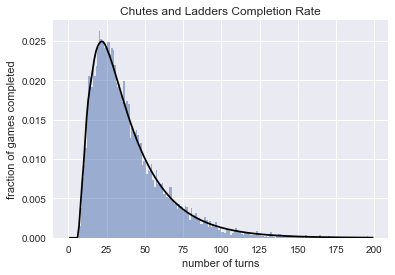

In [9]:
probs = [cl_probability(i)[-1] for i in range(200)]

plt.hist(sim_games, bins=range(200), normed=True,
         align='mid', alpha=0.5);
plt.plot(np.arange(1, 200), np.diff(probs), color='black')
plt.title('Chutes and Ladders Completion Rate')
plt.xlabel('number of turns')
plt.ylabel('fraction of games completed');

By eye it looks like our direct simulation was quite close to the Markov model, which indicates that we're on the right track in our thinking.

The cumulative distribution is also interesting:

/Users/User/Desktop/Repositorios/Cobb-Douglas-Funktion/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


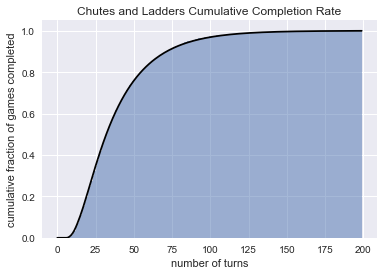

In [10]:
plt.hist(sim_games, bins=range(200), normed=True,
         align='mid', cumulative=True, alpha=0.5);
plt.plot(np.arange(200), probs, color='black');
plt.title('Chutes and Ladders Cumulative Completion Rate')
plt.xlabel('number of turns')
plt.ylabel('cumulative fraction of games completed');

From this, we can see that 90% of single-player games finish within about 72 moves, though it is possible for games to be much longer.

With two players, this translates to a 1% chance that the game will go 72 moves without either of the players winning. Assuming roughly 20 seconds per round, that is about 24 minutes of play time, though from personal experience I can say it feels roughly twenty times that long.

### Minimum Game Length

But what if you get *really* lucky... how quickly can the game end?
From our Markov chain results, we see that there is a nonzero probability of finishing the game in just seven moves, and this will happen about once in every 660 games:

In [11]:
probs[1:8]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015110596707818928]

The Markov chain approach doesn't immediately tell us *how* this happens, though the transition matrix encodes a sparse graph that can be used by ``scipy.sparse.csgraph`` to find one of these shortest paths:

In [12]:
from scipy.sparse.csgraph import shortest_path
lengths, predecessors = shortest_path(mat.T, indices=0, directed=True,
                                      unweighted=True, return_predecessors=True)

``lengths`` here is the length of the shortest path from state 0 to each of the other states:

In [13]:
lengths

array([ 0., inf,  1.,  1., inf,  1.,  1.,  2.,  2., inf,  2.,  2.,  2.,
        3.,  1.,  2., inf,  2.,  2.,  2.,  2., inf,  3.,  3.,  3.,  3.,
        3.,  4., inf,  4.,  4.,  2.,  3.,  3.,  3.,  3., inf,  3.,  1.,
        2.,  2.,  2.,  2.,  2.,  2.,  3.,  3., inf,  3., inf,  3., inf,
        4.,  4.,  4.,  4., inf,  5.,  5.,  5.,  5.,  5., inf,  6., inf,
        6.,  6.,  4.,  5.,  5.,  5., inf,  5.,  5.,  6.,  6.,  6.,  6.,
        6.,  6., inf,  7.,  7.,  7.,  4.,  5.,  5., inf,  5.,  5.,  5.,
        5.,  6., inf,  6., inf,  6.,  6., inf,  7.,  7.])

We can use the ``predecessors`` vector here to reconstruct one of the shortest paths to state 100:

In [14]:
path = [100]
while path[0] > 0:
    path.insert(0, predecessors[path[0]])
path

[0, 38, 39, 45, 67, 70, 75, 100]

## Typical Game Length

We've talked about the extremes, but how long should you expect the typical game to last?
The answer to that question depends on what you mean by *typical*.
Some common approaches to defining *typical* are the mean, median, or mode of game lengths.

The mean game length is the expected value of the number of turns, averaged over all possibilities and weighted by their relative probability:

In [15]:
turns = np.arange(1, len(probs))
np.dot(np.diff(probs), turns)

39.106460290714445

We see that, on average, a player will finish the game in about 39 turns.

This value, though, is weighted by game length, so the small possibility of having a very long game contributes to this estimate in an outsized way.
Often the median game length is a more useful statistic:

In [16]:
np.searchsorted(probs, 0.5)

32

This tells us that approximately 50% of games will be finished in fewer than 32 moves, and 50% will be finished in more than 32 moves.

But both the mean and the median are offset from the peak (or mode) of the probability distribution, which we can compute as follows:

In [17]:
np.argmax(np.diff(probs)) + 1

22

This says that you'll finish the game in 22 moves more often than any other specific number of moves.

Probably the most useful types of statistics for skewed probability distributions like this one, though, are quantiles. For example:

In [18]:
np.searchsorted(probs, [0.025, 0.975])

array([ 11, 106])

This tells us that 95% of the time, games will last between 11 and 106 turns.
Or, to tighten the constraints a bit:

In [19]:
np.searchsorted(probs, [0.25, 0.75])

array([22, 50])

half of all games will last between 22 and 50 moves.

## Learning More from the Markov Process

Aside from summary statistics, the Markov transition matrix for Chutes and Ladders can tell us a number of other interesting things, which we'll explore here.

### Shannon Entropy

One interesting thing we can explore is the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) of the distribution: you can think of the entropy as a measure of how "spread out" the distribution is in probability space; a high entropy state is one in which we have very little knowledge of where an individual draw will lie.

We can compute and visualize the entropy using the [``entropy``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function from SciPy's ``stats`` module.
Let's plot the entropy as a function of the number of turns played:

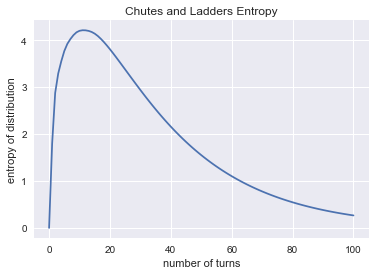

In [20]:
from scipy import stats

turns = np.arange(101)
entropy = [stats.entropy(cl_probability(turn)) for turn in turns]

plt.plot(turns, entropy)
plt.xlabel('number of turns')
plt.ylabel('entropy of distribution')
plt.title('Chutes and Ladders Entropy');

We see that the entropy is maximized after eleven turns:

In [21]:
np.argmax(entropy)

11

What this tells you is that when you complete 11 turns, you should expect positions of various players to be very spread out. Prior to this, the probability distribution is clumped near the beginning of the board. After 11 moves, you can take heart that you're unavoidably on the path to the game's end.

### Eigenvectors and Stationary States

The Markov transition matrix can be examined directly to learn about the dynamics of the game.
For example, the eigenvectors of a transition matrix with eigenvalue equal to one tell us about *stationary states*; that is, states which are unchanged after applying the transition matrix.

We can compute these eigenvectors this way:

In [22]:
evals, evecs = np.linalg.eig(mat)
evals[:10]

array([1.  +0.j  , 0.83+0.j  , 0.96+0.j  , 0.4 +0.65j, 0.4 -0.65j,
       0.76+0.j  , 0.6 +0.32j, 0.6 -0.32j, 0.24+0.59j, 0.24-0.59j])

There is only one stationary state in Chutes and Ladders (with eigenvalue equal to one); let's see what it is:

In [23]:
evecs[:, 0]

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

Graciously, the single stationary state is a completed game. What this means is that you are very unlikely to find yourself in an infinitely looping, unending game.
I doubt the game designers did this stationary state calculation when designing the game, but I bless them for their accidental success in this regard.

### Fundamental Matrix

As we have set up the transition matrix, once you reach state 100 you remain there with 100% probability.
In mathematical terms, the end of the game is an "absorbing state", because once you are there you cannot transition to any other state.
What this means is that Chutes and Ladders is an [absorbing Markov Chain](https://en.wikipedia.org/wiki/Absorbing_Markov_chain), and we can do a few more interesting things with the transition matrix.

This all starts with computing the [fundamental matrix](https://hips.seas.harvard.edu/blog/2013/02/15/the-fundamental-matrix-of-a-finite-markov-chain/) *N* of the absorbing Markov chain, which is a simple transformation of the Markov transition matrix:

In [24]:
M = cl_markov_matrix(jump_at_end=False)
N = np.linalg.inv(np.eye(100) - M[:100, :100])

(Note that we used the version of our process where jumps happen at the beginning of the turn, so that we can more easily reason about the effects of ladders and chutes).

The *(n,m)* entry of the fundamental matrix tells us the expected number of times that we will visit state *n* when starting at state *m* on our way to the absorbing state.

Let's plot these expected values when starting at state 0, the beginning of the game

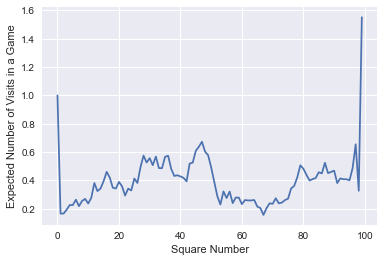

In [25]:
expected_visits = N[:, 0]
plt.plot(expected_visits)
plt.xlabel('Square Number')
plt.ylabel('Expected Number of Visits in a Game');

The profile is pretty interesting. The most striking feature is that you're expected to visit square 99 approximately 1.5 times per game, on average!
This is due to the fact that once you land on square 99, you have to roll a 1 to exit it; each additional turn that you don't roll a 1 is counted as another visit.

Let's look at the top few other most visited states:

In [26]:
col = N[:, 0]
np.argsort(col)[::-1][:5]

array([99,  0, 47, 97, 46])

The next most visited state is state 0, which you visit exactly once at the start of each game.
After that is square 47, which is visited about 3/4 times per game on average.
Interestingly, this square is the top of a chute, and thus is the most used of all chutes in the game.

We can also look at the least visited squares on the board:

In [27]:
np.argsort(col)[:5]

array([67,  1,  2,  3, 68])

Surprisingly, the least likely square is 67, and is visited even less often than square 1, which you have the possibility of hitting only once per game, if you roll a 1 on the first roll!
Looking at the graph above, it is clear that squares 55-75 or so are visited relatively rarely, due to the positions of chutes and of ladders within the game board.

#### The Big Chute and Big Ladder

One thing my daughter would probably like to know: how often will you to hit the "big slide" or the "big ladder" during a game? These are at squares 87, and 28, respectively:

In [28]:
col[87]

0.5251287063445976

In [29]:
col[28]

0.5757765406747606

We see that a player is expected to slide down the big chute a bit over once in every two games on average, and climb the big ladder slightly more often: just under six times in every ten games on average.

#### Time to Absorption

The fundamental matrix can also be used to compute other quantities; for example the matrix product with a column of ones gives the expected "time to absorption"; that is, the expected number of turns until finishing the game from any given square. Let's use the "jump-at-the-end" version of the matrix again:

In [30]:
np.set_printoptions(precision=1)
np.dot(N.T, np.ones(100))

array([39.7, 35.4, 40.2, 39.7, 37.6, 39.8, 39.6, 39.3, 39.1, 36.7, 39.2,
       38.7, 38.3, 37.9, 37.6, 37.1, 39.6, 35.9, 35.8, 35.7, 35.6, 34. ,
       34. , 34.5, 34.8, 35.1, 35.3, 35.4, 22.9, 37.4, 36.9, 36.7, 36.5,
       36.3, 36. , 35.8, 33.9, 35.7, 35.4, 34.9, 34.5, 34.6, 34. , 34.7,
       33.9, 32. , 31.7, 35.3, 30.5, 38.7, 28.9, 20.9, 29.9, 29.5, 29.1,
       28.6, 29.5, 28.6, 28.3, 27.2, 26.3, 25.5, 35.7, 22.6, 26.3, 20.8,
       20.8, 20.9, 20.5, 20.3, 20.3, 16.2, 21. , 21. , 18.1, 19.2, 20. ,
       20.6, 20.9, 21. ,  1. , 25.9, 24.8, 23.8, 22.9, 21.9, 21.2, 34.8,
       17.9, 18.1, 17.1, 16.2, 16.9, 21. , 12.3, 19.2, 11. , 11. , 20.9,
        6. ])

From the first square, the expected time to completion is 39.7 moves: this is half a move than the 39.2 moves we computed previously, because we're using a different form of the matrix (here we count climbing the ladder from square 80 to square 100 as one extra move)

This vector can tell us what the best first roll is: as my daughter has intuited, starting out by rolling a 1 and climbing the first ladder is best: it decreases your expected time to completion by five moves. The worst first roll is a 2: this actually increases your expected time to completion by 0.5 turns, on average: rolling a 2 to start is akin to moving *away* from the goal.

By the time you get to the 99th square, your espected time to completion is 6 moves, because you have a 1/6 chance of rolling the 1 required to win. Two squares back, on the 97th square, your expected time to completion goes up to 11 moves, because of the chute present on the 98th square.

The fundamental matrix lets you quantititatively explore a number of other properties of the game; for example, we could adjust the matrix to make square 80 an absorber as well, and ask how probable we are to complete the game there versus landing on square 100 directly. Or we could compute quantities such as the variance of the number of visits and number of steps above.
For more discussion of applications of the fundamental matrix of an absorbing Markov chain, see the [wikipedia article](https://en.wikipedia.org/wiki/Absorbing_Markov_chain).
A nice undergraduate-level introduction to these concepts can be found in Chapter 11 of Grinstead and Snell's “Introduction to Probability” (pdf available [here](http://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter11.pdf)).

## Visualizing the Board

Just for fun, let's use Python's tools to visualize these probability states in an intuitive way.
We'll use the above scan of the original Chutes and Ladders game as our background, and plot the probability distribution on top of this using a custom colormap with changing transparency

In [31]:
from matplotlib import colors

# Make a blue colorbar with increasing opacity
c = np.zeros((100, 4))
c[:, -1] = np.linspace(0, 1, 100)  # transparency gradient
c[:, 2] = 0.5  # make the map dark blue
TransparencyMap = colors.ListedColormap(c)


def show_board(turn):
    fig, ax = plt.subplots()
    board = plt.imread('ChutesAndLadders-board.gif')
    
    # Compute & reshape the probability vector
    prob = cl_probability(turn)
    prob = prob[1:].reshape(10, 10)[::-1]
    prob[::2] = prob[::2, ::-1]
    
    # Show result over the image of the board
    ax.imshow(board, alpha=0.8)
    im = ax.imshow(prob, extent=[10, 800, 810, 10],
                   norm=colors.LogNorm(vmin=1E-3, vmax=1),
                   cmap=TransparencyMap)
    fig.colorbar(im, ax=ax, label='Fraction of games')
    ax.axis('off')
    ax.set_title(f"Turn {turn}")
    
    return fig

Using this, we can visualize the probability distribution after any number of turns:

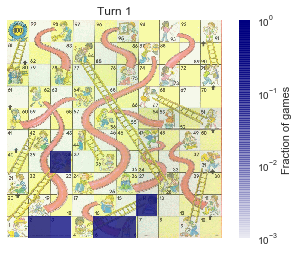

In [32]:
show_board(1);

After one turn, the distribution is quite tight: there are six possible states we can find ourselves in.

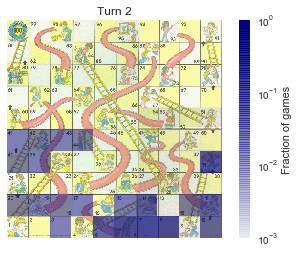

In [33]:
show_board(2);

After two turns, things become more spread out, though they are still clumped around a few more likely values.

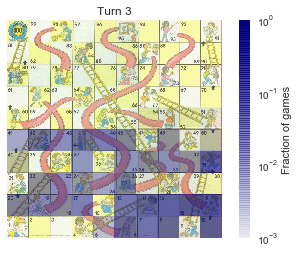

In [34]:
show_board(3);

After 3 turns, the distribution is getting even further apart.

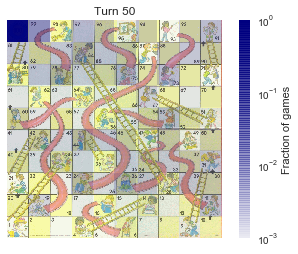

In [35]:
show_board(50);

After 50 turns, many games will be finished, but there's still a non-negligible probability of finding yourself in spaces across the board.

### Animating the Simulations

These board visualizations will be a bit more intuitive if we animate the results; here I'll do this using the excellent [ImageIO](http://imageio.github.io/) package to stitch together an animated GIF from the individual matplotlib plots.
(Note that you can also do this sort of animation [directly in matplotlib](http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), but matplotlib's GIF writer requires some extra command-line tools that ImageIO does not).

Let's start with a function that will build a GIF using ImageIO from a generator of matplotlib figures:

In [37]:
import imageio
from io import BytesIO

def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  # close figure when we're finished to prevent matplotlib warnings
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

Now we can create some simulations and make a GIF. I'll tweak the frame durations of the gif a bit to emphasize the more interesting earlier frames:

In [38]:
frames = [*range(15), *range(15, 50, 5), *range(50, 101, 10)]
sims = (show_board(i) for i in frames)

duration = np.zeros(len(frames))
duration[:8] = 0.5
duration[-1] = 1.0

make_gif(sims, 'ChutesAndLadders-sim.gif', fps=8, duration=list(duration))

The resulting GIF looks like this:

<img src='http://jakevdp.github.io/images/ChutesAndLadders-sim.gif' alt='[img: Chutes and Ladders animated simulation]'>

## Conclusion

I hope you've enjoyed this exploration of Chutes & Ladders, and even if you haven't, I'm certain you'll take solace in the fact that I did.
And to Jace: if you ever come across this post at some point years down the road, I hope you'll someday experience the joy of playing Chutes & Ladders with your kids for as many hours as I did with you.

Thanks for reading!

*This post was written entirely in the Jupyter notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/ChutesAndLadders.ipynb)
this notebook, or see a static view
[on nbviewer](http://nbviewer.jupyter.org/url/jakevdp.github.io/downloads/notebooks/ChutesAndLadders.ipynb).*